In [18]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
import helper
print("Done")

Done


## Load model

In [19]:
if torch.cuda.is_available():
    device = "cuda:0"#"cuda:0"
else:
    device = "cpu"
    
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

data = pd.read_csv(url, sep='\t')
    
#data = pd.read_csv('data/hindi_hatespeech.tsv', sep='\t')
data_development = shuffle(data)
labels = data_development['task_2']
# data_development = data
type(data_development['task_1'])

print("Done", device)

Done cuda:0


In [20]:
#Stopwords Removal
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences)
print('Total words:', len(non_unique))
print('Unique words:', len(V))
embedding_size = 640

Number of sentences:  4665
Total words: 141550
Unique words: 19836


In [21]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_hindi', device, len(V), embedding_size)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=19836, bias=True)
)
torch.Size([19837, 640]) torch.Size([640, 19836])


## Create Dataset

In [22]:
## create number array of sentences (replace each word with each numeric value)
x_data, max_len_curr = helper.sentence_to_numeric_arr(sentences, V)

## apply padding
padded = np.array(helper.padding(x_data, max_len_curr))

print(padded.shape)
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print(encoded_labels.shape)

(4665, 132)
(4665,)


In [23]:
#split data into train, valid & test set
batch_size = 64
train_loader, test_loader = helper.split_data_train_valid_test(padded, encoded_labels, batch_size)
print("Done")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Done


<ipython-input-24-893d87a531af>:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/20 Training Loss: 0.6798
Epoch: 2/20 Training Loss: 0.5991
Epoch: 3/20 Training Loss: 0.4180
Epoch: 4/20 Training Loss: 0.2473
Epoch: 5/20 Training Loss: 0.1422
Epoch: 6/20 Training Loss: 0.0978
Epoch: 7/20 Training Loss: 0.0693
Epoch: 8/20 Training Loss: 0.0423
Epoch: 9/20 Training Loss: 0.0299
Epoch: 10/20 Training Loss: 0.0275
Epoch: 11/20 Training Loss: 0.0222
Epoch: 12/20 Training Loss: 0.0244
Epoch: 13/20 Training Loss: 0.0224
Epoch: 14/20 Training Loss: 0.0135
Epoch: 15/20 Training Loss: 0.0174
Epoch: 16/20 Training Loss: 0.0191
Epoch: 17/20 Training Loss: 0.0123
Epoch: 18/20 Training Loss: 0.0169
Epoch: 19/20 Training Loss: 0.0158
Epoch: 20/20 Training Loss: 0.0121
Done


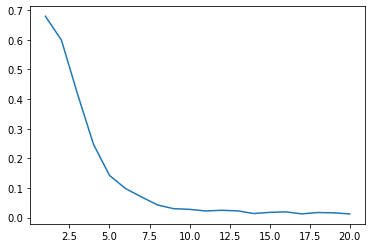

In [24]:
net, criterion = helper.initialize_SentimentLSTM_model_task3(len(V) + 1, batch_size, embedding_size, 32, 1, 2, device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 20  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN


training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#             net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task3_hindi.png') 
    
print("Done")

## Test set

In [9]:
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.1328
Test Accuracy: 0.72


## Testing Bengali Data on Hindi Classifier

In [25]:
#Reading Bengali data
bengali_data, labels = helper.get_bengali_data('data/bengali_hatespeech.csv')
# print(bengali_data)
print(bengali_data.shape, labels.shape)
bengali_sentences = helper.apply_stopword_removal(bengali_data)
print("Number of sentences: " , len(bengali_sentences))

## Building Vocabulary
bengali_V, bengali_non_unique = helper.build_vocabulary(bengali_sentences)
print('Total words:', len(bengali_non_unique))
print('Unique words:', len(bengali_V))

## Sentence to numeric array
x_data_bengali, max_len_curr = helper.sentence_to_numeric_arr(bengali_sentences, bengali_V)

## Apply Padding
padded = np.array(helper.padding(x_data_bengali, max_len_curr))

train_loader, test_loader = helper.split_data_train_valid_test(padded, labels, 64)
print("Done")

(4665, 3) (4665,)
Number of sentences:  4665
Total words: 64027
Unique words: 14482
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Done


<ipython-input-12-fcf209974ed7>:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/30 Training Loss: 0.6884
Epoch: 2/30 Training Loss: 0.5121
Epoch: 3/30 Training Loss: 0.2281
Epoch: 4/30 Training Loss: 0.1111
Epoch: 5/30 Training Loss: 0.0707
Epoch: 6/30 Training Loss: 0.0484
Epoch: 7/30 Training Loss: 0.0410
Epoch: 8/30 Training Loss: 0.0292
Epoch: 9/30 Training Loss: 0.0208
Epoch: 10/30 Training Loss: 0.0159
Epoch: 11/30 Training Loss: 0.0127
Epoch: 12/30 Training Loss: 0.0115
Epoch: 13/30 Training Loss: 0.0080
Epoch: 14/30 Training Loss: 0.0071
Epoch: 15/30 Training Loss: 0.0064
Epoch: 16/30 Training Loss: 0.0058
Epoch: 17/30 Training Loss: 0.0051
Epoch: 18/30 Training Loss: 0.0052
Epoch: 19/30 Training Loss: 0.0047
Epoch: 20/30 Training Loss: 0.0063
Epoch: 21/30 Training Loss: 0.0038
Epoch: 22/30 Training Loss: 0.0035
Epoch: 23/30 Training Loss: 0.0082
Epoch: 24/30 Training Loss: 0.0251
Epoch: 25/30 Training Loss: 0.0184
Epoch: 26/30 Training Loss: 0.0187
Epoch: 27/30 Training Loss: 0.0111
Epoch: 28/30 Training Loss: 0.0066
Epoch: 29/30 Training Loss: 0

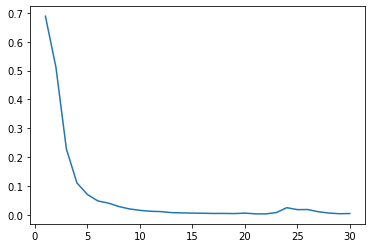

In [12]:
net, criterion = helper.initialize_SentimentLSTM_model_task3_bengali(len(V) + 1, batch_size, embedding_size, 32, 1, 2, device, weights1)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 30  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN


training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#             net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))

plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig("Task3_transfer_learning.png")
print("Done")

### Testing

In [13]:
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.5072
Test Accuracy: 0.75


## Training classifier on Bengali embeddings

In [ ]:
net, criterion = helper.initialize_SentimentLSTM_model_task3(len(bengali_V) + 1, batch_size, embedding_size, 32, 1, 2, device)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 50  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN


training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
#         if (step % print_every) == 0:            
#             ######################
#             ##### VALIDATION #####
#             ######################
#             net.eval()
#             valid_losses = []
#             v_h = net.init_hidden(batch_size, device)
            
#             for v_inputs, v_labels in valid_loader:
#                 v_inputs, v_labels = inputs.to(device), labels.to(device)
        
#                 v_h = tuple([each.data for each in v_h])
                
#                 v_output, v_h = net(v_inputs, batch_size)
#                 v_loss = criterion(v_output.squeeze(), v_labels.float())
#                 valid_losses.append(v_loss.item())

#             print("Epoch: {}/{}".format((epoch+1), n_epochs),
#                   "Step: {}".format(step),
#                   "Training Loss: {:.4f}".format(loss.item()),
#                   "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
#             net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))

plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig("Task3_bengali.png")
print("Done")

<ipython-input-26-dc5aab19ce58>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/50 Training Loss: 0.6895
Epoch: 2/50 Training Loss: 0.5946
Epoch: 3/50 Training Loss: 0.3771
Epoch: 4/50 Training Loss: 0.2356
Epoch: 5/50 Training Loss: 0.1515
Epoch: 6/50 Training Loss: 0.1064
Epoch: 7/50 Training Loss: 0.0791
Epoch: 8/50 Training Loss: 0.0661
Epoch: 9/50 Training Loss: 0.0579
Epoch: 10/50 Training Loss: 0.0411
Epoch: 11/50 Training Loss: 0.0413
Epoch: 12/50 Training Loss: 0.0342
Epoch: 13/50 Training Loss: 0.0290
Epoch: 14/50 Training Loss: 0.0206
Epoch: 15/50 Training Loss: 0.0243
Epoch: 16/50 Training Loss: 0.0210
Epoch: 17/50 Training Loss: 0.0177
Epoch: 18/50 Training Loss: 0.0166
Epoch: 19/50 Training Loss: 0.0180
Epoch: 20/50 Training Loss: 0.0222
Epoch: 21/50 Training Loss: 0.0145
Epoch: 22/50 Training Loss: 0.0177
Epoch: 23/50 Training Loss: 0.0154
Epoch: 24/50 Training Loss: 0.0098
Epoch: 25/50 Training Loss: 0.0095
Epoch: 26/50 Training Loss: 0.0088
Epoch: 27/50 Training Loss: 0.0120
Epoch: 28/50 Training Loss: 0.0094
Epoch: 29/50 Training Loss: 0

In [15]:
# import os 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    
    
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.5006
Test Accuracy: 0.74


## Hyperopt Implementation
### Note: Hyperopt was used for the selection of the model.

In [ ]:
def train_hyperopt(space)
    learning_rate = space['learning_rate']
    n_epochs = space['epochs']
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, amsgrad=True)
    clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'


    training_loss_epoches = []
    for epoch in range(n_epochs):
        h = net.init_hidden(batch_size, device)
        training_loss = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data for each in h])
            net.zero_grad()
            output, h = net(inputs, batch_size)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            training_loss.append(loss.item())
            nn.utils.clip_grad_norm(net.parameters(), clip)
            optimizer.step()
            
    net.eval()
    valid_losses = []
    v_h = net.init_hidden(batch_size, device)

    for v_inputs, v_labels in valid_loader:
        v_inputs, v_labels = inputs.to(device), labels.to(device)

        v_h = tuple([each.data for each in v_h])

        v_output, v_h = net(v_inputs, batch_size)
        v_loss = criterion(v_output.squeeze(), v_labels.float())
        valid_losses.append(v_loss.item())
        
        np.mean(valid_losses)
        return {'loss': np.mean(valid_losses), 'model': net, 'status': STATUS_OK}

space = {
        'learning_rate': hp.quniform('learning_rate', 0.001, 0.04, 0.005),
        'epochs': hp.quniform('epochs', 20, 200, 20),
        'train': train_loader,
        'y_train': y_train.to_numpy(),
        'val': val_loader}

    trials = Trials()
    best = fmin(fn=train_hyperopt,
                space=space,
                algo=tpe.suggest,
                max_evals=int(max_evals),
                trials=trials)